In [1]:
# training_loss = 0.43 (approx)
# training_acc = 0.8 (approx)

In [2]:
# TODO
# Hyperparameter Tuning
# Normalization
# Voice Manipulations (Spectrogram)
# Sort by Histogram (2 faces)
# Only RNN
# ResNeXt
# EfficientNet
# ResNet
# XceptionNet

In [3]:
# Importing the required libraries

import cv2
import numpy as np
import pandas as pd
import os
import glob
import sys
import time
import torch

sys.path.insert(0, "/kaggle/input/blazeface-pytorch")
from blazeface import BlazeFace

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [4]:
# Versions

print('Tensorflow version: 2.1.0-rc0')
print('OpenCV version:', cv2.__version__)

Tensorflow version: 2.1.0-rc0
OpenCV version: 4.1.2


In [5]:
# Initializing the paths

input_path = '/kaggle/input/deepfake-detection-challenge/'
train_dir = glob.glob(input_path + 'train_sample_videos/*.mp4')

In [6]:
# Reading the labels of training data

df_train = pd.read_json(input_path + 'train_sample_videos/metadata.json').transpose()
df_train.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


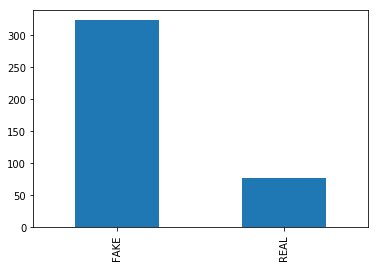

In [7]:
# Plotting the count of labels

# Fake class is in majority
df_train.label.value_counts().plot.bar()

In [8]:
df_train.label.value_counts()

FAKE    323
REAL     77
Name: label, dtype: int64

In [9]:
df_train.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [10]:
# Storing video labels in a dictionary
dic = {}
for ind in df_train.index: 
    if(df_train['label'][ind] == 'REAL'):
        dic[ind] = 0
    else:
        dic[ind] = 1

In [11]:
# Loading the BlazeFace model weights

gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
facedet = BlazeFace().to(gpu)
facedet.load_weights("/kaggle/input/blazeface-pytorch/blazeface.pth")
facedet.load_anchors("/kaggle/input/blazeface-pytorch/anchors.npy")
_ = facedet.train(False)

In [12]:
class VideoReader:
    """Helper class for reading one or more frames from a video file."""

    def __init__(self, verbose=True, insets=(0, 0)):
        """Creates a new VideoReader.

        Arguments:
            verbose: whether to print warnings and error messages
            insets: amount to inset the image by, as a percentage of 
                (width, height). This lets you "zoom in" to an image 
                to remove unimportant content around the borders. 
                Useful for face detection, which may not work if the 
                faces are too small.
        """
        self.verbose = verbose
        self.insets = insets

    def read_frames(self, path, num_frames, jitter=0, seed=None):
        """Reads frames from 90th frame continuously.

        Arguments:
            path: the video file
            num_frames: how many frames to read, -1 means the entire video
                (warning: this will take up a lot of memory!)
            jitter: if not 0, adds small random offsets to the frame indices;
                this is useful so we don't always land on even or odd frames
            seed: random seed for jittering; if you set this to a fixed value,
                you probably want to set it only on the first video 
        """
        assert num_frames > 0

        capture = cv2.VideoCapture(path)
        # frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
        # if frame_count <= 0: return None
        frame_idxs = np.linspace(90, 90 + num_frames - 1, num_frames, endpoint=True, dtype=np.int)
        # frame_idxs = np.linspace(0, frame_count - 1, num_frames, endpoint=True, dtype=np.int)
        if jitter > 0:
            np.random.seed(seed)
            jitter_offsets = np.random.randint(-jitter, jitter, len(frame_idxs))
            frame_idxs = np.clip(frame_idxs + jitter_offsets, 0, frame_count - 1)

        result = self._read_frames_at_indices(path, capture, frame_idxs)
        capture.release()
        return result

    def read_frames_at_indices(self, path, frame_idxs):
        """Reads frames from a video and puts them into a NumPy array.

        Arguments:
            path: the video file
            frame_idxs: a list of frame indices. Important: should be
                sorted from low-to-high! If an index appears multiple
                times, the frame is still read only once.

        Returns:
            - a NumPy array of shape (num_frames, height, width, 3)
            - a list of the frame indices that were read

        Reading stops if loading a frame fails, in which case the first
        dimension returned may actually be less than num_frames.

        Returns None if an exception is thrown for any reason, or if no
        frames were read.
        """
        assert len(frame_idxs) > 0
        capture = cv2.VideoCapture(path)
        result = self._read_frames_at_indices(path, capture, frame_idxs)
        capture.release()
        return result

    def _read_frames_at_indices(self, path, capture, frame_idxs):
        try:
            frames = []
            idxs_read = []
            for frame_idx in range(frame_idxs[0], frame_idxs[-1] + 1):
                # Get the next frame, but don't decode if we're not using it.
                ret = capture.grab()
                if not ret:
                    if self.verbose:
                        print("Error grabbing frame %d from movie %s" % (frame_idx, path))
                    break

                # Need to look at this frame?
                current = len(idxs_read)
                if frame_idx == frame_idxs[current]:
                    ret, frame = capture.retrieve()
                    if not ret or frame is None:
                        if self.verbose:
                            print("Error retrieving frame %d from movie %s" % (frame_idx, path))
                        break

                    frame = self._postprocess_frame(frame)
                    frames.append(frame)
                    idxs_read.append(frame_idx)

            if len(frames) > 0:
                return np.stack(frames), idxs_read
            if self.verbose:
                print("No frames read from movie %s" % path)
            return None
        except:
            if self.verbose:
                print("Exception while reading movie %s" % path)
            return None    

    def _postprocess_frame(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if self.insets[0] > 0:
            W = frame.shape[1]
            p = int(W * self.insets[0])
            frame = frame[:, p:-p, :]

        if self.insets[1] > 0:
            H = frame.shape[1]
            q = int(H * self.insets[1])
            frame = frame[q:-q, :, :]

        return frame

In [13]:
class FaceExtractor:
    """Wrapper for face extraction workflow."""
    
    def __init__(self, video_read_fn, facedetn):
        """Creates a new FaceExtractor.

        Arguments:
            video_read_fn: a function that takes in a path to a video file
                and returns a tuple consisting of a NumPy array with shape
                (num_frames, H, W, 3) and a list of frame indices, or None
                in case of an error
            facedet: the face detector object
        """
        self.video_read_fn = video_read_fn
        self.facedet = facedet
    
    def process_videos(self, input_dir, filenames, video_idxs):
        """For the specified selection of videos, grabs one or more frames 
        from each video, runs the face detector, and tries to find the faces 
        in each frame.

        The frames are split into tiles, and the tiles from the different videos 
        are concatenated into a single batch. This means the face detector gets
        a batch of size len(video_idxs) * num_frames * num_tiles (usually 3).

        Arguments:
            input_dir: base folder where the video files are stored
            filenames: list of all video files in the input_dir
            video_idxs: one or more indices from the filenames list; these
                are the videos we'll actually process

        Returns a list of dictionaries, one for each frame read from each video.

        This dictionary contains:
            - video_idx: the video this frame was taken from
            - frame_idx: the index of the frame in the video
            - frame_w, frame_h: original dimensions of the frame
            - faces: a list containing zero or more NumPy arrays with a face crop
            - scores: a list array with the confidence score for each face crop

        If reading a video failed for some reason, it will not appear in the 
        output array. Note that there's no guarantee a given video will actually
        have num_frames results (as soon as a reading problem is encountered for 
        a video, we continue with the next video).
        """
        target_size = self.facedet.input_size

        videos_read = []
        frames_read = []
        frames = []
        tiles = []
        resize_info = []
        for video_idx in video_idxs:
            # Read the full-size frames from this video.
            filename = filenames[video_idx]
            video_path = os.path.join(input_dir, filename)
            result = self.video_read_fn(video_path)

            # Error? Then skip this video.
            if result is None: continue

            videos_read.append(video_idx)

            # Keep track of the original frames (need them later).
            my_frames, my_idxs = result
            frames.append(my_frames)
            frames_read.append(my_idxs)

            # Split the frames into several tiles. Resize the tiles to 128x128.
            my_tiles, my_resize_info = self._tile_frames(my_frames, target_size)
            tiles.append(my_tiles)
            resize_info.append(my_resize_info)

        # Put all the tiles for all the frames from all the videos into
        # a single batch.
        batch = np.concatenate(tiles)

        # Run the face detector. The result is a list of PyTorch tensors, 
        # one for each image in the batch.
        all_detections = self.facedet.predict_on_batch(batch, apply_nms=False)

        result = []
        offs = 0
        for v in range(len(tiles)):
            # Not all videos may have the same number of tiles, so find which 
            # detections go with which video.
            num_tiles = tiles[v].shape[0]
            detections = all_detections[offs:offs + num_tiles]
            offs += num_tiles

            # Convert the detections from 128x128 back to the original frame size.
            detections = self._resize_detections(detections, target_size, resize_info[v])

            # Because we have several tiles for each frame, combine the predictions
            # from these tiles. The result is a list of PyTorch tensors, but now one
            # for each frame (rather than each tile).
            num_frames = frames[v].shape[0]
            frame_size = (frames[v].shape[2], frames[v].shape[1])
            detections = self._untile_detections(num_frames, frame_size, detections)

            # The same face may have been detected in multiple tiles, so filter out
            # overlapping detections. This is done separately for each frame.
            detections = self.facedet.nms(detections)

            for i in range(len(detections)):
                # Crop the faces out of the original frame.
                faces = self._add_margin_to_detections(detections[i], frame_size, 0.2)
                faces = self._crop_faces(frames[v][i], faces)

                # Add additional information about the frame and detections.
                scores = list(detections[i][:, 16].cpu().numpy())
                frame_dict = { "video_idx": videos_read[v],
                               "frame_idx": frames_read[v][i],
                               "frame_w": frame_size[0],
                               "frame_h": frame_size[1],
                               "faces": faces, 
                               "scores": scores }
                result.append(frame_dict)

                # TODO: could also add:
                # - face rectangle in original frame coordinates
                # - the keypoints (in crop coordinates)
                
        return result

    def process_video(self, video_path):
        """Convenience method for doing face extraction on a single video."""
        input_dir = os.path.dirname(video_path)
        filenames = [ os.path.basename(video_path) ]
        return self.process_videos(input_dir, filenames, [0])

    def _tile_frames(self, frames, target_size):
        """Splits each frame into several smaller, partially overlapping tiles
        and resizes each tile to target_size.

        After a bunch of experimentation, I found that for a 1920x1080 video,
        BlazeFace works better on three 1080x1080 windows. These overlap by 420
        pixels. (Two windows also work but it's best to have a clean center crop
        in there as well.)

        I also tried 6 windows of size 720x720 (horizontally: 720|360, 360|720;
        vertically: 720|1200, 480|720|480, 1200|720) but that gives many false
        positives when a window has no face in it.

        For a video in portrait orientation (1080x1920), we only take a single
        crop of the top-most 1080 pixels. If we split up the video vertically,
        then we might get false positives again.

        (NOTE: Not all videos are necessarily 1080p but the code can handle this.)

        Arguments:
            frames: NumPy array of shape (num_frames, height, width, 3)
            target_size: (width, height)

        Returns:
            - a new (num_frames * N, target_size[1], target_size[0], 3) array
              where N is the number of tiles used.
            - a list [scale_w, scale_h, offset_x, offset_y] that describes how
              to map the resized and cropped tiles back to the original image 
              coordinates. This is needed for scaling up the face detections 
              from the smaller image to the original image, so we can take the 
              face crops in the original coordinate space.    
        """
        num_frames, H, W, _ = frames.shape

        # Settings for 6 overlapping windows:
        # split_size = 720
        # x_step = 480
        # y_step = 360
        # num_v = 2
        # num_h = 3

        # Settings for 2 overlapping windows:
        # split_size = min(H, W)
        # x_step = W - split_size
        # y_step = H - split_size
        # num_v = 1
        # num_h = 2 if W > H else 1

        split_size = min(H, W)
        x_step = (W - split_size) // 2
        y_step = (H - split_size) // 2
        num_v = 1
        num_h = 3 if W > H else 1

        splits = np.zeros((num_frames * num_v * num_h, target_size[1], target_size[0], 3), dtype=np.uint8)

        i = 0
        for f in range(num_frames):
            y = 0
            for v in range(num_v):
                x = 0
                for h in range(num_h):
                    crop = frames[f, y:y+split_size, x:x+split_size, :]
                    splits[i] = cv2.resize(crop, target_size, interpolation=cv2.INTER_AREA)
                    x += x_step
                    i += 1
                y += y_step

        resize_info = [split_size / target_size[0], split_size / target_size[1], 0, 0]
        return splits, resize_info

    def _resize_detections(self, detections, target_size, resize_info):
        """Converts a list of face detections back to the original 
        coordinate system.

        Arguments:
            detections: a list containing PyTorch tensors of shape (num_faces, 17) 
            target_size: (width, height)
            resize_info: [scale_w, scale_h, offset_x, offset_y]
        """
        projected = []
        target_w, target_h = target_size
        scale_w, scale_h, offset_x, offset_y = resize_info

        for i in range(len(detections)):
            detection = detections[i].clone()

            # ymin, xmin, ymax, xmax
            for k in range(2):
                detection[:, k*2    ] = (detection[:, k*2    ] * target_h - offset_y) * scale_h
                detection[:, k*2 + 1] = (detection[:, k*2 + 1] * target_w - offset_x) * scale_w

            # keypoints are x,y
            for k in range(2, 8):
                detection[:, k*2    ] = (detection[:, k*2    ] * target_w - offset_x) * scale_w
                detection[:, k*2 + 1] = (detection[:, k*2 + 1] * target_h - offset_y) * scale_h

            projected.append(detection)

        return projected    
    
    def _untile_detections(self, num_frames, frame_size, detections):
        """With N tiles per frame, there also are N times as many detections.
        This function groups together the detections for a given frame; it is
        the complement to tile_frames().
        """
        combined_detections = []

        W, H = frame_size
        split_size = min(H, W)
        x_step = (W - split_size) // 2
        y_step = (H - split_size) // 2
        num_v = 1
        num_h = 3 if W > H else 1

        i = 0
        for f in range(num_frames):
            detections_for_frame = []
            y = 0
            for v in range(num_v):
                x = 0
                for h in range(num_h):
                    # Adjust the coordinates based on the split positions.
                    detection = detections[i].clone()
                    if detection.shape[0] > 0:
                        for k in range(2):
                            detection[:, k*2    ] += y
                            detection[:, k*2 + 1] += x
                        for k in range(2, 8):
                            detection[:, k*2    ] += x
                            detection[:, k*2 + 1] += y

                    detections_for_frame.append(detection)
                    x += x_step
                    i += 1
                y += y_step

            combined_detections.append(torch.cat(detections_for_frame))

        return combined_detections
    
    def _add_margin_to_detections(self, detections, frame_size, margin=0.2):
        """Expands the face bounding box.

        NOTE: The face detections often do not include the forehead, which
        is why we use twice the margin for ymin.

        Arguments:
            detections: a PyTorch tensor of shape (num_detections, 17)
            frame_size: maximum (width, height)
            margin: a percentage of the bounding box's height

        Returns a PyTorch tensor of shape (num_detections, 17).
        """
        offset = torch.round(margin * (detections[:, 2] - detections[:, 0]))
        detections = detections.clone()
        detections[:, 0] = torch.clamp(detections[:, 0] - offset*2, min=0)            # ymin
        detections[:, 1] = torch.clamp(detections[:, 1] - offset, min=0)              # xmin
        detections[:, 2] = torch.clamp(detections[:, 2] + offset, max=frame_size[1])  # ymax
        detections[:, 3] = torch.clamp(detections[:, 3] + offset, max=frame_size[0])  # xmax
        return detections
    
    def _crop_faces(self, frame, detections):
        """Copies the face region(s) from the given frame into a set
        of new NumPy arrays.

        Arguments:
            frame: a NumPy array of shape (H, W, 3)
            detections: a PyTorch tensor of shape (num_detections, 17)

        Returns a list of NumPy arrays, one for each face crop. If there
        are no faces detected for this frame, returns an empty list.
        """
        faces = []
        for i in range(len(detections)):
            ymin, xmin, ymax, xmax = detections[i, :4].cpu().numpy().astype(np.int)
            face = frame[ymin:ymax, xmin:xmax, :]
            faces.append(face)
        return faces

    def keep_only_best_face(self, crops):
        """For each frame, only keeps the face with the highest confidence. 
        
        This gets rid of false positives, but obviously is problematic for 
        videos with two people!

        This is an optional postprocessing step. Modifies the original
        data structure.
        """
        for i in range(len(crops)):
            frame_data = crops[i]
            if len(frame_data["faces"]) > 0:
                frame_data["faces"] = frame_data["faces"][:1]
                frame_data["scores"] = frame_data["scores"][:1]    

In [14]:
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

In [15]:
def face_extract_on_video(video_path):
    # Find the faces for frames_per_video captured frames in the video
    faces = face_extractor.process_video(video_path)

    # In case only one person in the video, the other detections are false positives
    # The face with highest confidence is taken
    face_extractor.keep_only_best_face(faces)
    # TODO: def sort_by_histogram(self, crops) for videos with 2 people

    features = []
    for frame_data in faces:
        for face in frame_data["faces"]:
            resized_face = isotropically_resize_image(face, input_size)
            resized_face = make_square_image(resized_face)
            features.append(resized_face)

    x = frames_per_video - np.array(features).shape[0]

    # No face found
    if(x == frames_per_video):
        return(None, None)

    if(x != 0):
        # Pre-padding for efficient training (Done when features found is less than frames_per_video)
        features = np.concatenate((np.zeros((x, 229, 229, 3)), np.array(features)))
    return(features, dic[video_path.split('/')[-1]])        

In [16]:
def face_extract_on_video_set(video_paths):
    # Find the faces (ROI) for frames_per_video frames in the the given videos
    roi = []
    labels = []
    for x in video_paths:
        features, label = face_extract_on_video(x)
        if(label == None):
            continue
        roi.append(features)
        labels.append(label)

        # Oversampling
        if(label == 0):
            roi.append(features)
            roi.append(features)
            labels.append(label)
            labels.append(label)
    return(roi, labels)

In [17]:
frames_per_video = 20  # 20 frames starting from 90th frame will be captured
input_size = 229       # 229x229x3 (square-fitted)
batch_size = 64
# epochs = 160
n = len(train_dir)

In [18]:
# Taking the base model as Inception V3 and initializing its weight with imagenet

input_tensor = Input(shape = (229, 229, 3))
cnn_model = InceptionV3(input_tensor = input_tensor, weights = None, include_top = False, pooling = 'avg')
cnn_model.load_weights('/kaggle/input/inception-pretrained/inception_v3.h5')
cnn_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 229, 229, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 114, 114, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 114, 114, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 114, 114, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [19]:
# Building the model architecture

rnn = Sequential()

# LSTM layer
rnn.add(LSTM(256, return_sequences = False, dropout = 0.5, recurrent_dropout = 0.5, input_shape = (frames_per_video, 2048)))

# Fully Connected Layer
rnn.add(Dense(256, activation = 'tanh'))

# Dropout for regularization
rnn.add(Dropout(0.5))

# Output layer
rnn.add(Dense(2, activation = 'softmax'))

# Compile the model
rnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               2360320   
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 2,426,626
Trainable params: 2,426,626
Non-trainable params: 0
_________________________________________________________________


In [20]:
video_reader = VideoReader()
video_read_fn = lambda x: video_reader.read_frames(x, num_frames = frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [21]:
t1 = time.time()
roi, labels = face_extract_on_video_set(train_dir)
print('ROI extraction time taken: ', time.time() - t1)

ROI extraction time taken:  460.07745456695557


In [22]:
# One Hot Encoding train_labels
train_labels = []
for x in labels:
    if(x == 0):
        train_labels.append([1, 0])
    else:
        train_labels.append([0, 1])

In [23]:
np.array(roi).shape

(530, 20, 229, 229, 3)

In [24]:
t1 = time.time()
result = []
for i in range(np.array(roi).shape[0]):
    result.append(cnn_model.predict(np.array(roi[i])))
print('Feature extraction time taken: ', time.time() - t1)

Feature extraction time taken:  532.0822386741638


In [25]:
np.array(result).shape

(530, 20, 2048)

In [26]:
np.array(train_labels).shape

(530, 2)

In [27]:
def early_stop_acc():
    while(True):
        t1 = time.time()
        history = rnn.fit(np.array(result), np.array(train_labels), epochs = 1, batch_size = batch_size, shuffle = False, verbose = 0)
        print('Epoch: {}' .format(count))
        print('{}/{} [==============================] - {}s - loss: {} - accuracy: {}' .format(x, x, '%.2f'%(time.time() - t1), '%.4f'%(history.history['loss'][-1]), '%.4f'%(history.history['accuracy'][-1])))
        count += 1
        if(history.history['accuracy'][-1] >= 0.8):
            print('Model saved based on threshold accuracy...')
            rnn.save('deepfake_predictor_acc_0.8.h5')
            break

In [28]:
def early_stop_loss(count):
    while(True):
        t1 = time.time()
        history = rnn.fit(np.array(result), np.array(train_labels), epochs = 1, batch_size = batch_size, shuffle = False, verbose = 0)
        print('Epoch: {}' .format(count))
        print('{}/{} [==============================] - {}s - loss: {} - accuracy: {}' .format(x, x, '%.2f'%(time.time() - t1), '%.4f'%(history.history['loss'][-1]), '%.4f'%(history.history['accuracy'][-1])))
        count += 1
        if(history.history['loss'][-1] <= 0.43):
            print('Model saved based on threshold loss...')
            rnn.save('deepfake_predictor_loss_0.43.h5')
            break

In [29]:
# Training

count = 1
x = np.array(train_labels).shape[0]
print('Train on {} samples...' .format(x))
while True:
    t1 = time.time()
    history = rnn.fit(np.array(result), np.array(train_labels), epochs = 1, batch_size = batch_size, shuffle = False, verbose = 0)
    print('Epoch: {}' .format(count))
    print('{}/{} [==============================] - {}s - loss: {} - accuracy: {}' .format(x, x, '%.2f'%(time.time() - t1), '%.4f'%(history.history['loss'][-1]), '%.4f'%(history.history['accuracy'][-1])))
    count += 1
    
    if(history.history['accuracy'][-1] >= 0.8):
        print('Model saved based on threshold accuracy...')
        rnn.save('deepfake_predictor_acc_0.8.h5')
        early_stop_loss(count)
        break
        
    if(history.history['loss'][-1] <= 0.43):
        print('Model saved based on threshold loss...')
        rnn.save('deepfake_predictor_loss_0.43.h5')
        early_stop_acc(count)
        break

Train on 530 samples...
Epoch: 1
530/530 [==============================] - 5.39s - loss: 0.8332 - accuracy: 0.5415
Epoch: 2
530/530 [==============================] - 3.15s - loss: 0.8135 - accuracy: 0.4962
Epoch: 3
530/530 [==============================] - 2.95s - loss: 0.7829 - accuracy: 0.4755
Epoch: 4
530/530 [==============================] - 2.94s - loss: 0.7748 - accuracy: 0.5151
Epoch: 5
530/530 [==============================] - 2.97s - loss: 0.7024 - accuracy: 0.5642
Epoch: 6
530/530 [==============================] - 2.97s - loss: 0.7376 - accuracy: 0.5321
Epoch: 7
530/530 [==============================] - 2.95s - loss: 0.7005 - accuracy: 0.5698
Epoch: 8
530/530 [==============================] - 2.96s - loss: 0.6974 - accuracy: 0.5547
Epoch: 9
530/530 [==============================] - 2.99s - loss: 0.7032 - accuracy: 0.5736
Epoch: 10
530/530 [==============================] - 3.00s - loss: 0.6869 - accuracy: 0.5698
Epoch: 11
530/530 [==============================] - 2.

In [30]:
# Deleting existing model from memory

del rnn